In [1]:
import torch
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score

In [2]:
# Load fast tokenizer
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base", use_fast=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

In [3]:
# Use CUDA if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
def load_hdf5_data(file_path):
    with h5py.File(file_path, "r") as f:
        functions = [func.decode("utf-8") for func in f["functionSource"][:]]
        labels = np.column_stack([
            f["CWE-119"][:],
            f["CWE-120"][:],
            f["CWE-469"][:],
            f["CWE-476"][:],
            f["CWE-other"][:]
        ])
    print(f"Loaded {len(functions)} samples from {file_path}")
    return functions, labels

In [6]:
# File paths
train_file = "/kaggle/input/vdisc-vulnerability-dataset/VDISC_train/VDISC_train.hdf5"
val_file = "/kaggle/input/vdisc-vulnerability-dataset/VDISC_validate/VDISC_validate.hdf5"
test_file = "/kaggle/input/vdisc-vulnerability-dataset/VDISC_test/VDISC_test.hdf5"

# Load data
train_functions, train_labels = load_hdf5_data(train_file)
val_functions, val_labels = load_hdf5_data(val_file)
test_functions, test_labels = load_hdf5_data(test_file)

Loaded 1019471 samples from /kaggle/input/vdisc-vulnerability-dataset/VDISC_train/VDISC_train.hdf5
Loaded 127476 samples from /kaggle/input/vdisc-vulnerability-dataset/VDISC_validate/VDISC_validate.hdf5
Loaded 127419 samples from /kaggle/input/vdisc-vulnerability-dataset/VDISC_test/VDISC_test.hdf5


In [7]:
import numpy as np
import pandas as pd

# Function to downsample dataset while maintaining equal class distribution and excluding a class
def downsample_data(functions, labels, target_size=100000, exclude_class_index=None):
    label_indices = np.argmax(labels, axis=1)  # Convert one-hot labels to class indices
    df = pd.DataFrame({'function': functions, 'label': label_indices})  # Create DataFrame

    # **Remove the excluded class if necessary**
    if exclude_class_index is not None:
        df = df[df['label'] != exclude_class_index]

    # Get unique classes after exclusion
    num_classes = df['label'].nunique()

    # Calculate the number of samples per class
    samples_per_class = target_size // num_classes

    # Downsample or augment each class to the required size (samples_per_class)
    df_balanced = pd.DataFrame(columns=df.columns)  # Start with an empty DataFrame to concatenate the balanced classes

    # Iterate through each class to downsample or augment
    for label in df['label'].unique():
        class_data = df[df['label'] == label]
        
        if len(class_data) < samples_per_class:
            # If the class has fewer samples than the target, augment by sampling with replacement
            augmented_data = class_data.sample(n=samples_per_class, replace=True, random_state=42)
            df_balanced = pd.concat([df_balanced, augmented_data], ignore_index=True)
        else:
            # If the class has enough samples, downsample randomly without replacement
            downsampled_data = class_data.sample(n=samples_per_class, replace=False, random_state=42)
            df_balanced = pd.concat([df_balanced, downsampled_data], ignore_index=True)

    # Shuffle the balanced dataset to mix the data points
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    # Re-map labels to ensure they are continuous (from 0 to num_classes-1)
    unique_labels = sorted(df_balanced['label'].unique())  # Get unique labels
    label_map = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}  
    df_balanced['label'] = df_balanced['label'].map(label_map)  # Re-index labels

    # Convert labels back to one-hot encoding
    num_classes = len(unique_labels)  # Update to the new number of classes after exclusion
    labels_balanced = np.eye(num_classes)[df_balanced['label'].tolist()]

    return df_balanced['function'].tolist(), labels_balanced

# CWE-469 is the 3rd class (index 2 in labels), but after argmax it may vary.
exclude_class_index = 2  # Change this if needed

# Downsample Train, Validation, and Test Sets (with excluded class)
train_functions_down, train_labels_down = downsample_data(train_functions, train_labels, target_size=100000, exclude_class_index=exclude_class_index)
val_functions_down, val_labels_down = downsample_data(val_functions, val_labels, target_size=20000, exclude_class_index=exclude_class_index)
test_functions_down, test_labels_down = downsample_data(test_functions, test_labels, target_size=20000, exclude_class_index=exclude_class_index)

# Print the sizes of the downsampled datasets
print("Downsampled Train Size:", len(train_functions_down))
print("Downsampled Validation Size:", len(val_functions_down))
print("Downsampled Test Size:", len(test_functions_down))


Downsampled Train Size: 100000
Downsampled Validation Size: 20000
Downsampled Test Size: 20000


In [8]:
print("Train Functions Shape:", len(train_functions_down))
print("Train Labels Shape:", train_labels_down.shape)

print("Validation Functions Shape:", len(val_functions_down))
print("Validation Labels Shape:", val_labels_down.shape)

print("Test Functions Shape:", len(test_functions_down))
print("Test Labels Shape:", test_labels_down.shape)



Train Functions Shape: 100000
Train Labels Shape: (100000, 4)
Validation Functions Shape: 20000
Validation Labels Shape: (20000, 4)
Test Functions Shape: 20000
Test Labels Shape: (20000, 4)


In [10]:
# Tokenization function
    
def gpu_tokenize_data(functions, labels):
    tokens = tokenizer(functions, truncation=True, padding=True, max_length=256, return_tensors="pt")
    tokens = {k: v.to(device) for k, v in tokens.items()}
    labels_tensor = torch.tensor(np.argmax(labels, axis=1), dtype=torch.long).to(device)
    return tokens, labels_tensor


# Tokenize & move tensors to GPU
train_tokens, train_labels_tensor = gpu_tokenize_data(train_functions_down, train_labels_down)
val_tokens, val_labels_tensor = gpu_tokenize_data(val_functions_down, val_labels_down)
test_tokens, test_labels_tensor = gpu_tokenize_data(test_functions_down, test_labels_down)

# Load CodeBERT model
model = RobertaForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=5)
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Define model (ensure it's initialized before moving to device)
model = RobertaForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=4)  # Changed from 5 to 4
model.to(device)

# Define optimizer and loss function (ensure they're set up)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)  # Adjust as needed
loss_fn = torch.nn.CrossEntropyLoss()  # Adjust based on task

# Create PyTorch Dataset
train_dataset = TensorDataset(train_tokens["input_ids"], train_tokens["attention_mask"], train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Use AMP for mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Training loop
epochs = 2
for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", unit="batch")

    for batch in progress_bar:
        batch = [x.to(device, non_blocking=True) for x in batch]  # Move batch data to GPU
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():  # Mixed precision training
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)

        scaler.scale(loss).backward()  # Scales loss to prevent underflow
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

print("Training Complete!")


Device: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-bd514d6268ff>:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1:   0%|          | 0/6250 [00:00<?, ?batch/s]<ipython-input-12-bd514d6268ff>:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision training
Epoch 1: 100%|██████████| 6250/6250 [25:08<00:00,  4.14batch/s, loss=0.789]


Epoch 1 | Loss: 0.8090


Epoch 2: 100%|██████████| 6250/6250 [25:08<00:00,  4.14batch/s, loss=0.325] 

Epoch 2 | Loss: 0.5809
Training Complete!


In [13]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  # Import tqdm for progress bar

# Create dataset & DataLoader
test_dataset = TensorDataset(test_tokens["input_ids"], test_tokens["attention_mask"])
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # Adjust batch size as needed

# Evaluation in mini-batches
model.eval()
predictions = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="Evaluating", unit="batch")  # Initialize progress bar
    
    for batch in progress_bar:
        input_ids, attention_mask = [x.to(device) for x in batch]

        # Forward pass with optional mixed precision
        with torch.cuda.amp.autocast():
            preds = model(input_ids=input_ids, attention_mask=attention_mask).logits
            predicted_probs = torch.softmax(preds, dim=1)

        predictions.append(predicted_probs.cpu())

        # Update progress bar with estimated memory usage
        progress_bar.set_postfix(mem=f"{torch.cuda.memory_allocated() / 1e6:.2f} MB")

# Concatenate results
predicted_probs = torch.cat(predictions).numpy()


Evaluating:   0%|          | 0/1250 [00:00<?, ?batch/s]<ipython-input-13-f3161965d79b>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 1250/1250 [01:25<00:00, 14.66batch/s, mem=4657.77 MB]


In [14]:
# Convert to class labels
predicted_labels = np.argmax(predicted_probs, axis=1)
test_labels_np = np.argmax(test_labels_down, axis=1)

In [15]:
# Classification Report
print(classification_report(test_labels_np, predicted_labels, target_names=["CWE-120", "CWE-119", "CWE-476", "CWE-other"]))

              precision    recall  f1-score   support

     CWE-120       0.67      0.66      0.66      5000
     CWE-119       0.71      0.80      0.75      5000
     CWE-476       0.82      0.74      0.78      5000
   CWE-other       0.67      0.65      0.66      5000

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000



In [16]:
# Compute F1 Score, Precision, Recall
f1 = f1_score(test_labels_np, predicted_labels, average="macro")
precision = precision_score(test_labels_np, predicted_labels, average="macro")
recall = recall_score(test_labels_np, predicted_labels, average="macro")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


F1 Score: 0.7124374371767975
Precision: 0.7149621073978845
Recall: 0.71235


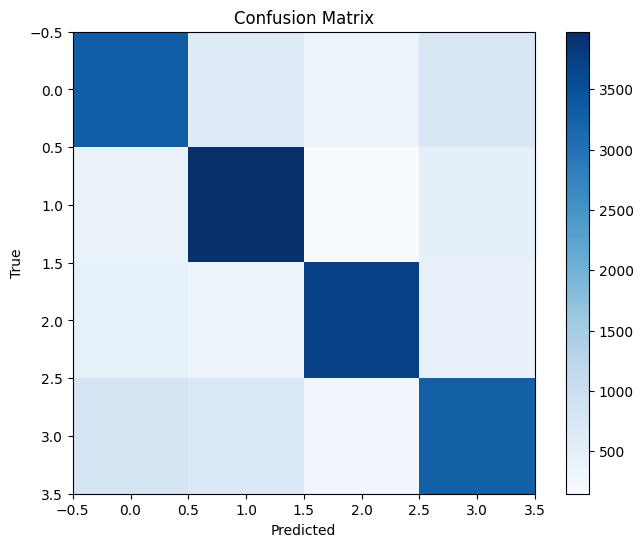

In [17]:
# Confusion Matrix
cm = confusion_matrix(test_labels_np, predicted_labels)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



In [18]:
# ROC-AUC
roc_auc = roc_auc_score(test_labels_np, predicted_probs, average="macro", multi_class="ovr")
print(f"ROC-AUC: {roc_auc}")

ROC-AUC: 0.9010509050000001
